In [137]:
from itertools import chain
from functools import partial

import scipy
from scipy import stats
from scipy.optimize import fmin
from scipy.stats import norm
from scipy.stats import beta
from scipy.special import gamma as gammaf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import random
from numpy.random import choice
import time
import re

sns.set(color_codes=True)
from math import exp, log

# Fitter bâton bêta
On découpe aléatoirement un génome en N fragments et on récupère la taille des fragments obtenus.
On cherche à vérifier que la distribution de la taille de ces fragments suit une loi bêta(1,N).

In [2]:
def get_parts(longueur, nbr_frag):
    """
    découpe aléatoirement un génome 
    <longueur>: longueur du génome à découper
    <nbr_frag>: nombre de fragments souhaités
    Return <nll>: liste de taille des fragments obtenus
    """
    cuts = set()
    while len(cuts) < nbr_frag - 1:
        cuts.add(random.randint(1, longueur - 1))
    cuts = [0] + list(sorted(cuts)) + [longueur]
    return [cuts[i + 1] - cuts[i] for i in range(len(cuts) - 1)]

On affiche l'histogramme de la distribution des tailles desfragments. 

Ici on a coupé un génome de taille 1 000 000 en N = 60 000 morceaux.

On affiche également la densité de la loi bêta de paramètres : 1,N

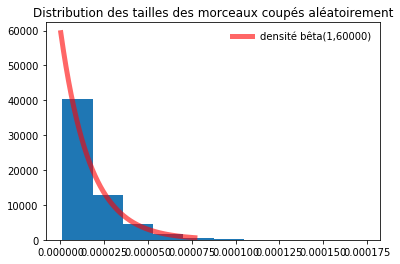

In [3]:
a=1
b=60000

taille = get_parts(1000000, 60000)

t = sum(taille)
taille = [i / t for i in taille] #normalise les tailles pour qu'elles soient comprises entre 0 et 1

x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 60000)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
plt.hist(taille)
plt.legend(loc='best', frameon=False)
plt.title("Distribution des tailles des morceaux coupés aléatoirement")
plt.show()

On remarque que la courbe de la densité de la loi bêta(1,60000) a la même allure que la distribution des tailles.

## Méthodes moments

Nous allons ensuite "fitter" cette distribution en utilisant la méthode des moments et celle du maximum de vraisemblance afin d'estimer les paramètres de la loi bêta.

Soit la moyenne empirique : $m$ = $ \frac{1}{n} $$\sum_{i=1}^{n} x_{i}$ 

et la variance : $v$ = $ \frac{1}{n} $$\sum_{i=1}^{n} (x_{i}-m)$

D'après la méthode des moments on estime les paramètres de la loi bêta($\alpha$, $\beta$) 

$\alpha$ = $m$($ \frac{m(1-m)}{v}$$ - 1)$

$\beta$ = $(1-m)$($ \frac{m(1-m)}{v}$$-1)$


In [4]:
mean = np.mean(taille)
var = np.var(taille, ddof=1)

alpha1 = mean ** 2 * (1 - mean) / var - mean
beta1 = alpha1 * (1 - mean) / mean

print("Les paramètres estimés par la méthode des moments sont : alpha = ", alpha1, ", beta = ",beta1)


Les paramètres estimés par la méthode des moments sont : alpha =  1.0755860845764211 , beta =  64534.08948850069


## Vraisemblance

En utilisant la méthode du maximum de vraisemblance : 
 
 $l($$\alpha$, $\beta$$)$ $=$ $\sum_{i=1}^{n} $$-$log$f_{(\alpha, \beta)}(x_{i})$
 
 où $f_{(\alpha, \beta)}$ : la fonction densité de la loi bêta($\alpha$, $\beta$)
 
 L'estimateur du maximum de vraisemblance de $\alpha$ et $\beta$ est donné par :
 
 $(\hat{\alpha}, \hat{\beta})$ = $\underset{\alpha>0, \beta>0 }{argmin}$ $l($$\alpha$, $\beta$$)$

In [5]:
def betaNLL(param, *args):
    """
    log négative vraisemblance pour bêta
    <param>: liste des paramètres à "fitter"
    <args>: données à "fitter"
    Return <nll>: log négative vraisemblance à minimiser
    """  
    a, b = param
    data = args[0]
    pdf = beta.pdf(data,a,b,loc=0,scale=1)
    lg = np.log(pdf)
    nll = -1*np.sum(lg)
    return nll

In [6]:
result = fmin(betaNLL, [1, 1], args=(taille,))
alpha2, beta2 = result

print("Les paramètres estimés par la méthode de la vraisemblance sont : \nalpha = ", alpha2, ", beta = ",beta2)


Optimization terminated successfully.
         Current function value: -600643.241549
         Iterations: 128
         Function evaluations: 256
Les paramètres estimés par la méthode de la vraisemblance sont : 
alpha =  1.18504698795277 , beta =  71101.1087590054


On affiche ensuite les densités des lois bêta dont les paramètres ont été trouvés précedemment.

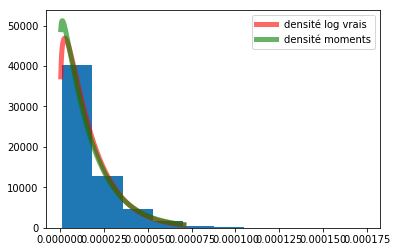

In [7]:
xx = np.linspace(beta.ppf(0.01, alpha2, beta2), beta.ppf(0.99, alpha2, beta2), 60000)
plt.plot(xx, beta.pdf(xx, alpha2, beta2),'r-', lw=5, alpha=0.6, label='densité log vrais')
plt.plot(xx, beta.pdf(xx, alpha1, beta1),'g-', lw=5, alpha=0.6, label='densité moments')
plt.legend()
plt.hist(taille)
plt.show()

# Fitter données expérimentales

In [46]:
def f(x, g, n):
    """
    fonction loi beta qui correspond à la distribution théorique de la taille des reads
    :param x: taille des reads
    :param g: taille du génome
    :param n: nombre de fragments
    :return: fonction loi beta
    """
    return  n* (1 - x/g) ** (n - 1)

On trace cette fonction pour un génome de taille 1000000 et de nombre de fragments 60 000.

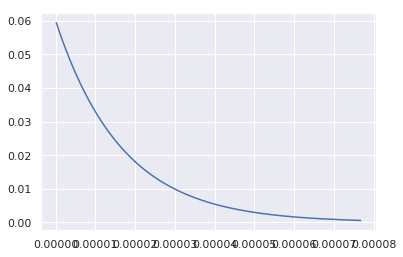

In [24]:
a=1
b=60000

x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 1000)
plt.plot(x, f(x,1000000,b))

In [3]:
monFichier = open("../Documents/Donnees/DRR164913.fastq", "r") #MINION
taille = []
f = []
norm = []

for line in monFichier:
    fields = line.strip().split()
    for idx, word in enumerate(fields):
        f.append(word)

for i, element in enumerate(f):
    if element.endswith("/1") and i + 1 < len(f):
        taille.append(len(f[i + 1]))

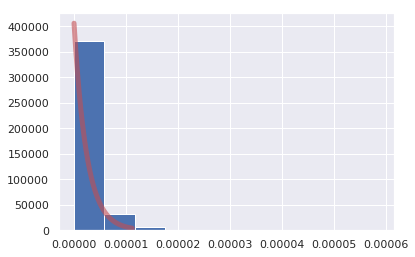

[4.09995000e+05 2.09928387e+05 1.07488822e+05 5.50370266e+04
 2.81803347e+04 1.44290207e+04 7.38800351e+03 3.78283026e+03
 1.93689528e+03 9.91733428e+02 5.07789001e+02 2.59998685e+02
 1.33124668e+02 6.81624908e+01 3.49005194e+01 1.78697244e+01
 9.14962603e+00 4.68477091e+00 2.39868323e+00 1.22816570e+00
 6.28840572e-01 3.21976125e-01 1.64856590e-01 8.44089461e-02
 4.32185478e-02 2.21284700e-02 1.13300579e-02 5.80112732e-03
 2.97024443e-03 1.52079792e-03 7.78664460e-04 3.98683923e-04
 2.04129897e-04 1.04516302e-04 5.35132074e-05 2.73991729e-05
 1.40285715e-05 7.18272055e-06 3.67759598e-06 1.88294913e-06
 9.64079139e-07 4.93612681e-07 2.52731547e-07 1.29399360e-07
 6.62528137e-08 3.39215783e-08 1.73678996e-08 8.89238125e-09
 4.55290275e-09 2.33108548e-09]


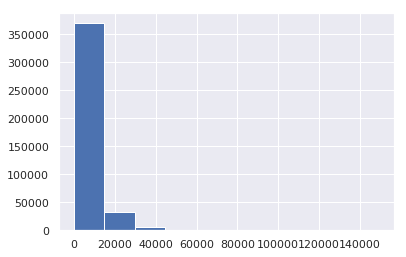

In [113]:
t = sum(taille)
maxi = max(taille)
a=1
b=len(taille)
g = 1000000000
norm = [i / t for i in taille]

x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 60000)

plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
plt.hist(norm)
plt.show()

xx = np.linspace(0, 80000)
weights = np.ones_like(taille) / float(len(taille))
print(f(xx,g,b)) #tester fonction pour déterminer la taille du génome #problème
#plt.plot(xx, f(xx,g,b), 'g')
plt.hist(taille)
plt.show()

# Simulation séquençage

On écrit un programme permettant de découper un génome en N morceaux où N suit soit une loi normale, uniforme ou de poisson.

On trace cette fonction pour un génome de taille 1000000 et de nombre de fragments 60 000.

In [133]:
lois = ['normale', 'uniforme', 'poisson']

def fracture(echantillons, taille_genome, loi='normale', parametres=None):
    """
    Fracture une liste d'échantillons en utilisant un nombre de fractures variables de loi n = Norm(N, sigma)
    :param sigma:
    :param n: Ecart-type
    :param echantillons:
    :return:
    """
    if loi == 'normale':
        n, sigma = parametres
        nfrag = n + np.random.randn(len(echantillons)) * sigma
        
    elif loi == 'uniforme':
        nmin, nmax = parametres
        nfrag = np.random.uniform(nmin, nmax, len(echantillons))

    elif loi == 'poisson':
        n = parametres
        nfrag = np.random.poisson(n, len(echantillons))
        
    else:
        raise NotImplementedError(loi)
    échantillons_fracturés = []
    échantillon_fracture = []

    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    for index, (nombre_fragments, taille_échantillon) in enumerate(zip(map(int, nfrag), echantillons)):

        if nombre_fragments > taille_échantillon:
            raise ValueError(
                '\n\n\n'
                'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
                'Vous pouvez: \n'
                '\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
                '\t- Augmenter la taille des échantillons à fracturer\n'
            )
        # Il y aura n - 1 fractures pour obtenir n elements
        nombre_fractures = nombre_fragments - 1

        # Une fracture sera placée avant l'index désigné, donc une fracture
        #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
        fractures = set()
        while len(fractures) < nombre_fractures:
            fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
        if len(fractures) != nombre_fractures:
            if len(fractures) < nombre_fractures:
                raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
            fractures = set(list(fractures)[:nombre_fractures])
            
        fractures = list(fractures)
        
        fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
        échantillon_fracturé = [
            fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
        ]
        if sum(échantillon_fracturé) != taille_échantillon:
            raise RuntimeError(
                "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
                f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
                f" fragments de différence entre ce qu'on attendais et ce qu'on a"
                f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
            )
        échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
        échantillons_fracturés.append(échantillon_fracturé)
        
    return échantillons_fracturés

In [110]:
def choices(array, weights, k):
    """
    fonction comme random choice sans remplacement
    """
    assert len(array) > k
    index, cumulated = 0, []
    for w in weights:
        cumulated.append(index)
        index += w
    choi = set()
    while len(choi) < k:
        i = random.random() * index
        j = next(y for y, x in reversed(list(enumerate(cumulated))) if i > x)
        choi.add(j)
    return [array[k] for k in choi]

On tire N morceaux tel que les petit morceaux aient plus de chance d'être tirés grâce à la fonction random.choice  

99526
99526


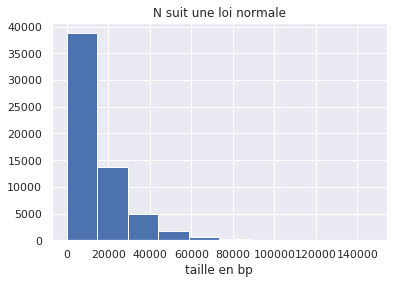

148303
148303


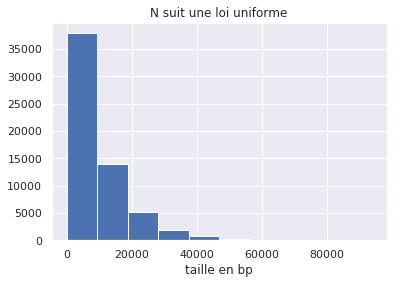

10009114
10009114


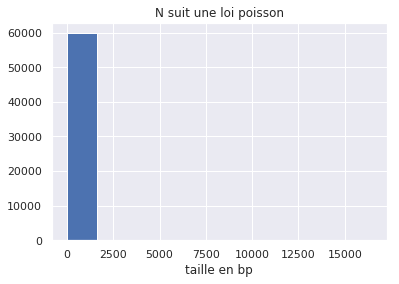

In [160]:
taille_genome =1500000
nombre_morceaux = 60000

def poid(element, tout, maxi, mini):
    p = maxi - element + 10
    return p

for loi, parametres in [
    ('normale', (100, 10)),
    ('uniforme', (100, 200)),
    ('poisson', 10000)
]:
    fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, taille_genome, loi, parametres)))
    print(len(fragments))
    maxi, mini = max(fragments), min(fragments)
    sumi = sum(fragments)
    poids = list(map(partial(poid, mini=mini, maxi=maxi, tout=fragments), fragments))
    
    
    s=sum(poids)
    
    print(len(fragments))
    fragments = choice(fragments, 60000, p=poids/s, replace=False)
    #fragments = choices(fragments, poids, k=1000)
    
    weights = np.ones_like(fragments) / float(len(fragments))
    plt.xlabel('taille en bp')
    plt.title('N suit une loi %s' %loi)
    plt.hist(fragments)
    plt.show()


# Théorie : on calcule les densités des lois composées

## Loi bêta - uniforme

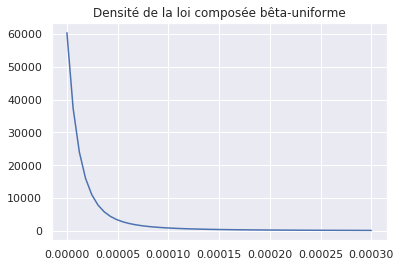

In [139]:
x=np.linspace(0.000000000001,0.0003)
def f(x, b):
    return (1./b)*((b*np.exp((b-1)*np.log(1-x)))/(np.log(1-x))-(np.exp((b-1)*np.log(1-x)))/((np.log(1-x))**2)+(np.exp((-np.log(1-x)))/((np.log(1-x))**2)))
b=60000*2

plt.title('Densité de la loi composée bêta-uniforme')
plt.plot(x, f(x,b))
plt.show()


## Loi bêta-poisson

On calcule la densité de la loi composée H de la loi bêta F et de poisson G.

$p_{H}(x) = \int_{0}^{+\infty} p_{F}(x|\theta) p_{G}(\theta)d\theta$

$p_{H}(x) = \int_{0}^{+\infty}n(1-x)^{n-1}\frac{\lambda^{n}e^{-\lambda}}{n!}dn$

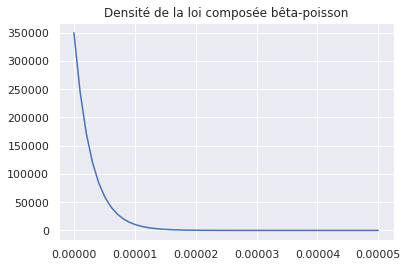

In [157]:
x=np.linspace(0,0.00005)
l=350000

def f(x, l):
    return l*np.exp(-l*x)+(np.exp(-l)*l*l)/(1-x)

plt.title('Densité de la loi composée bêta-poisson')
plt.plot(x,f(x,l))
#plt.hist(taille) #problème ne coincide pas
plt.show()

In [162]:
l, c = [], 0
for i in range(len(x) - 1):
    m = (x[i] + x[i + 1]) / 2
    y = m * f(m,60000*2)
    c += y
    l.append(c)

l

[0.05301745465475605,
 0.3547353706690936,
 0.9027389680122604,
 1.6297879418643835,
 2.4719339219635903,
 3.383300674331003,
 4.3345912840842065,
 5.308255662827063,
 6.2941981634857305,
 7.286771669433209,
 8.282881543715257,
 9.280858297729399,
 10.279812354557542,
 11.27927443144787,
 12.278999004309918,
 13.278858506184358,
 14.278787047551193,
 15.278750768332522,
 16.278732344494667,
 17.278722946166283,
 18.278718087533278,
 19.278715495790177,
 20.278714021614835,
 21.278713084264325,
 22.278712389915988,
 23.278711789135443,
 24.27871120494524,
 25.278710596612598,
 26.27870994145981,
 27.27870922574608,
 28.27870844010528,
 29.278707577267102,
 30.278706630920617,
 31.278705595148335,
 32.278704464144774,
 33.27870323207668,
 34.278701893013675,
 35.27870044089391,
 36.27869886950704,
 37.27869717248584,
 38.278695343302026,
 39.27869337526422,
 40.27869126151694,
 41.278688995040106,
 42.278686568648794,
 43.27868397499312,
 44.27868120655819,
 45.27867825566407,
 46.278675

In [161]:
x=np.linspace(0,0.0003)
N=20000000000000
l=60000
def f(l, N):
    """
    espérance bêta-poisson
    """
    return  -N*np.exp(-l*N)-(1/l)*np.exp(-l*N)+1/l+l*l*np.exp(-l)*(-N-np.log(np.abs(1-N)))


print(f(l,N))

print(1/(1+60000)) #espérance loi bêta

1.6666666666666667e-05
1.666638889351844e-05
